In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=3bf86582a6a55c4d3c2daa72a39eb6cf49189606472ab2f422eeedd90fc5c2ee
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# Chuẩn bị dữ liệu

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from keras.initializers import GlorotNormal
import tensorflow as tf
from keras.regularizers import l2

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML-dataset/DGA/RNN/dataset_all.csv')
df

,Unnamed: 0,domain,class
0,0,google.com,legit
1,1,facebook.com,legit
2,2,youtube.com,legit
3,3,baidu.com,legit
4,4,yahoo.com,legit
...,...,...,...
1799995,1799995,yacoouemkmmeaqiu.org,ramdo
1799996,1799996,yaucyikacowiogem.org,ramdo
1799997,1799997,iumgkaoasgoyiccy.org,ramdo
1799998,1799998,aemosuaokkwmqqmq.org,ramdo


In [ ]:
# Lọc ra lớp 'legit'
filtered_df = df[df['class'] != 'legit']
filtered_df

,Unnamed: 0,domain,class
1000000,1000000,uhbqolxf.org,conficker
1000001,1000001,gzhwfdwnjrg.cc,conficker
1000002,1000002,oyxiufvc.ws,conficker
1000003,1000003,ufaqzt.cn,conficker
1000004,1000004,cejzf.org,conficker
...,...,...,...
1799995,1799995,yacoouemkmmeaqiu.org,ramdo
1799996,1799996,yaucyikacowiogem.org,ramdo
1799997,1799997,iumgkaoasgoyiccy.org,ramdo
1799998,1799998,aemosuaokkwmqqmq.org,ramdo


In [ ]:
# Trộn dữ liệu trước khi mã hóa nhãn
shuffled_data = filtered_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Định nghĩa một từ điển ánh xạ tùy chỉnh để đảm bảo thứ tự mong muốn mà không có lớp 'legit'
custom_mapping = {
    'conficker': 0,
    'cryptolocker': 1,
    'zeus': 2,
    'pushdo': 3,
    'rovnix': 4,
    'tinba': 5,
    'matsnu': 6,
    'ramdo': 7
}

# Các lớp duy nhất trước khi mã hóa nhãn
unique_classes_before_encoding = shuffled_data['class'].unique()
print("Unique classes before label encoding:", unique_classes_before_encoding)

# Áp dụng mã hóa nhãn bằng cách sử dụng ánh xạ tùy chỉnh
shuffled_data['class'] = shuffled_data['class'].map(custom_mapping)

# Mã hóa nhãn lớp
label_encoder = LabelEncoder()
shuffled_data['class'] = label_encoder.fit_transform(shuffled_data['class'])

# Các lớp duy nhất sau khi mã hóa nhãn
unique_classes_after_encoding = label_encoder.classes_
print("Unique classes after label encoding:", unique_classes_after_encoding)

# Định nghĩa một từ điển ánh xạ đảo ngược
reverse_mapping = {v: k for k, v in custom_mapping.items()}

# In ra số được gán cho mỗi lớp sau khi mã hóa nhãn
for class_number in unique_classes_after_encoding:
    class_name = reverse_mapping[class_number]
    print(f"Class: {class_name}, Encoded number: {class_number}")

Unique classes before label encoding: ['zeus' 'rovnix' 'tinba' 'cryptolocker' 'ramdo' 'pushdo' 'matsnu'
 'conficker']
Unique classes after label encoding: [0 1 2 3 4 5 6 7]
Class: conficker, Encoded number: 0
Class: cryptolocker, Encoded number: 1
Class: zeus, Encoded number: 2
Class: pushdo, Encoded number: 3
Class: rovnix, Encoded number: 4
Class: tinba, Encoded number: 5
Class: matsnu, Encoded number: 6
Class: ramdo, Encoded number: 7


In [ ]:
# Mã hóa tên miền
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(shuffled_data['domain'])
encoded_domain = tokenizer.texts_to_sequences(shuffled_data['domain'])

# In dữ liệu đã mã hóa và nhãn lớp
encoded_data_with_labels = pd.DataFrame({'Encoded Domain': encoded_domain, 'Encoded Class': shuffled_data['class']})
print(encoded_data_with_labels)

# Lấp đầy các chuỗi để đảm bảo độ dài đồng nhất
max_sequence_length = max([len(seq) for seq in encoded_domain])
print("Max sequence length: " + str(max_sequence_length))
padded_domain = pad_sequences(encoded_domain, maxlen=max_sequence_length)

# Xác định kích thước từ vựng
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because index 0 is reserved
print(f"Vocab size: {vocab_size}")

                                           Encoded Domain  Encoded Class
0       [25, 9, 9, 29, 5, 8, 23, 5, 25, 16, 18, 5, 29,...              2
1       [28, 18, 11, 14, 27, 30, 17, 7, 31, 10, 20, 11...              2
2       [21, 2, 1, 21, 14, 2, 9, 18, 8, 9, 2, 11, 9, 5...              4
3       [19, 9, 9, 1, 2, 22, 16, 3, 3, 18, 1, 1, 6, 3,...              5
4       [24, 7, 7, 11, 27, 14, 13, 17, 4, 26, 12, 20, ...              1
...                                                   ...            ...
799995  [25, 11, 20, 29, 37, 12, 12, 25, 24, 7, 32, 15...              2
799996              [13, 5, 3, 14, 5, 9, 5, 17, 6, 4, 12]              3
799997  [8, 24, 3, 14, 11, 18, 27, 11, 3, 16, 19, 16, ...              1
799998  [15, 12, 10, 9, 13, 12, 5, 15, 2, 23, 12, 2, 1...              6
799999  [11, 13, 24, 15, 8, 4, 23, 3, 20, 10, 23, 27, ...              1

[800000 rows x 2 columns]
Max sequence length: 40
Vocab size: 38


In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(padded_domain, shuffled_data['class'], test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (640000, 40)
Shape of X_test: (160000, 40)
Shape of y_train: (640000,)
Shape of y_test: (160000,)


In [ ]:
# Tạo list chứa kết quả
ML_Model = []
acc = []
prec = []
rec = []
f1_scores = []

#Hàm lưu kết quả
def storeResults(model, a,b,c,d):
  ML_Model.append(model)
  acc.append(round(a, 3))
  prec.append(round(b, 3))
  rec.append(round(c, 3))
  f1_scores.append(round(d, 3))

# So sánh với các phương pháp khác để phân loại đa nhãn

# AB

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Khởi tạo mô hình cây quyết định yếu (weak learner)
weak_learner = DecisionTreeClassifier(max_depth=1)

# Khởi tạo mô hình AdaBoost với 50 cây quyết định và thuật toán SAMME.R
model = AdaBoostClassifier(
    base_estimator=weak_learner,
    n_estimators=50,
    algorithm='SAMME.R',
    random_state=42
)

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [ ]:
storeResults('AB', accuracy, precision, recall, f1)

# NN

In [ ]:
# Khởi tạo mô hình Sequential
model = Sequential()

# Thêm lớp ẩn với 100 nút và hàm kích hoạt ReLU
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))

# Thêm lớp đầu ra với số nút bằng số lớp (giả sử đây là bài toán phân loại nhiều lớp)
# Ở đây sử dụng hàm softmax cho phân loại nhiều lớp
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Biên dịch mô hình với bộ tối ưu hóa Adam, learning rate 0.001 và hàm mất mát categorical crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Tính các chỉ số đo lường hiệu suất
accuracy_nn = accuracy_score(y_test, y_pred_classes)
precision_nn = precision_score(y_test, y_pred_classes, average='weighted')
recall_nn = recall_score(y_test, y_pred_classes, average='weighted')
f1_nn = f1_score(y_test, y_pred_classes, average='weighted')

In [ ]:
storeResults('NN', accuracy_nn, precision_nn, recall_nn, f1_nn)

# RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Khởi tạo mô hình RandomForest với các tham số cụ thể
rf_model = RandomForestClassifier(
    n_estimators=10,             # Số lượng cây
    max_features=5,              # Số lượng thuộc tính tối đa tại mỗi lần phân tách
    min_samples_split=5,         # Không phân tách các tập con nhỏ hơn 5
    random_state=42
)

# Huấn luyện mô hình
rf_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = rf_model.predict(X_test)

# Tính các chỉ số đo lường hiệu suất
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')

In [ ]:
storeResults('RF', accuracy_rf, precision_rf, recall_rf, f1_rf)

# SVM

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(
    C=1.0,               # Tham số C
    kernel='rbf',        # Sử dụng RBF kernel
    gamma='scale',       # Sử dụng gamma='scale' theo mặc định của scikit-learn
    tol=0.10,            # Epsilon (E) = 0.10
    random_state=42
)

# Huấn luyện mô hình
svm_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = svm_model.predict(X_test)

# Tính các chỉ số đo lường hiệu suất
accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred, average='weighted')
recall_svm = recall_score(y_test, y_pred, average='weighted')
f1_svm = f1_score(y_test, y_pred, average='weighted')

In [ ]:
storeResults('SVM', accuracy_svm, precision_svm, recall_svm, f1_svm)

# DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Khởi tạo mô hình Decision Tree với các tham số cụ thể
dt_model = DecisionTreeClassifier(
    min_samples_leaf=2,      # Ít nhất hai mẫu trong các lá
    min_samples_split=5,     # Không chia nhỏ các cây nhỏ hơn năm
    max_depth=100,           # Độ sâu tối đa là 100
    max_leaf_nodes=None,     # Không giới hạn số lượng lá
    criterion='gini',        # Sử dụng tiêu chí Gini (có thể thay bằng 'entropy' nếu muốn)
    random_state=42
)

# Huấn luyện mô hình
dt_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = dt_model.predict(X_test)

# Tính các chỉ số đo lường hiệu suất
accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred, average='weighted')
recall_dt = recall_score(y_test, y_pred, average='weighted')
f1_dt = f1_score(y_test, y_pred, average='weighted')

In [ ]:
storeResults('DT', accuracy_dt, precision_dt, recall_dt, f1_dt)

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Khởi tạo mô hình k-Nearest Neighbours với các tham số cụ thể
knn_model = KNeighborsClassifier(
    n_neighbors=5,            # Sử dụng 5 hàng xóm
    metric='euclidean',       # Sử dụng khoảng cách Euclidean
    weights='uniform'         # Sử dụng trọng số đồng nhất
)

# Huấn luyện mô hình
knn_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = knn_model.predict(X_test)

# Tính các chỉ số đo lường hiệu suất
accuracy_knn = accuracy_score(y_test, y_pred)
precision_knn = precision_score(y_test, y_pred, average='weighted')
recall_knn = recall_score(y_test, y_pred, average='weighted')
f1_knn = f1_score(y_test, y_pred, average='weighted')

In [ ]:
storeResults('KNN', accuracy_knn, precision_knn, recall_knn, f1_knn)

# LA_Mul07

In [ ]:
from keras.models import load_model
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Tải mô hình với các đối tượng tùy chỉnh
custom_objects = {'SeqSelfAttention': SeqSelfAttention, 'SeqWeightedAttention': SeqWeightedAttention}
la_mul07 = load_model('/content/drive/MyDrive/ML/la_mul07_model.h5', custom_objects=custom_objects)

# Dự đoán trên tập kiểm tra
y_pred = la_mul07.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Tính toán các chỉ số hiệu suất
accuracy_la = accuracy_score(y_test, y_pred_classes)
precision_la = precision_score(y_test, y_pred_classes, average='weighted')
recall_la = recall_score(y_test, y_pred_classes, average='weighted')
f1_la = f1_score(y_test, y_pred_classes, average='weighted')

# Lưu kết quả
storeResults('LA_Mul07', accuracy_la, precision_la, recall_la, f1_la)

# In ra các chỉ số
print(f'Accuracy: {accuracy_la}')
print(f'Precision: {precision_la}')
print(f'Recall: {recall_la}')
print(f'F1 Score: {f1_la}')


5000/5000 [==============================] - 182s 36ms/step
Accuracy: 0.997125
Precision: 0.9971542517228605
Recall: 0.997125
F1 Score: 0.9971248034422205


# So sánh

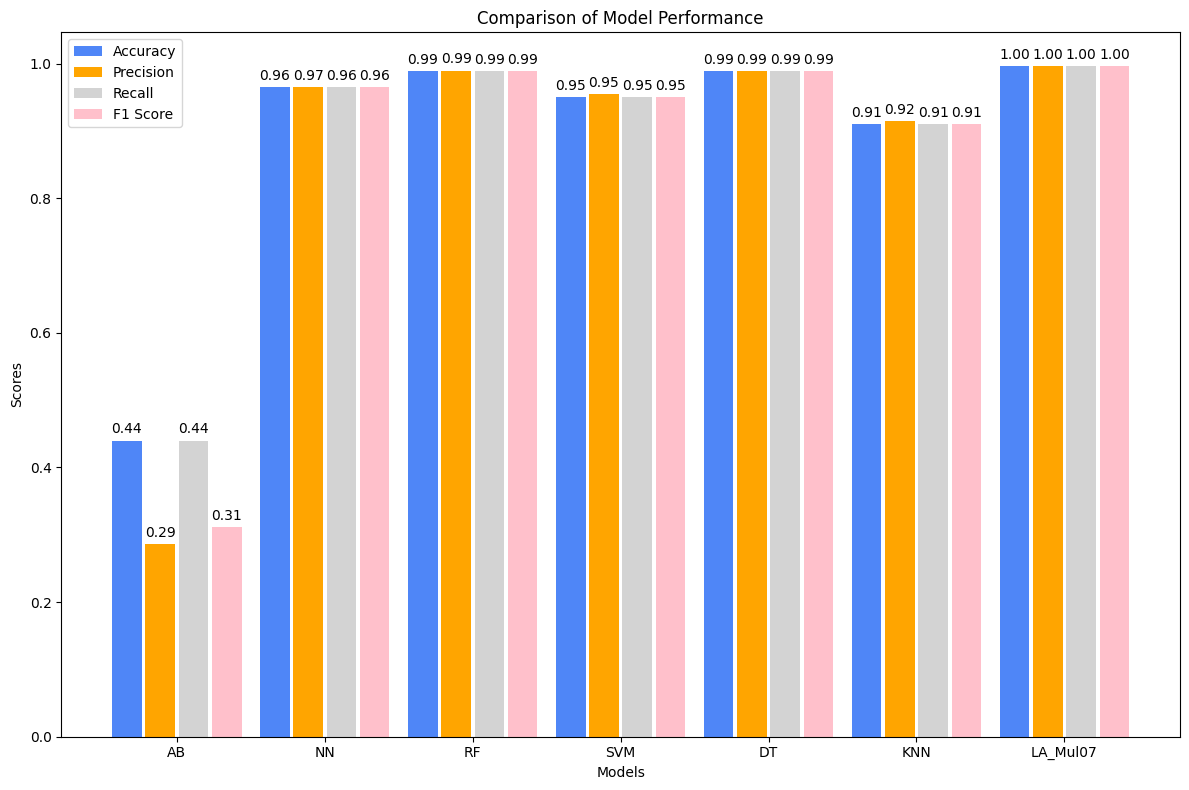

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Định nghĩa tên các mô hình và các chỉ số của chúng
labels = ['AB', 'NN', 'RF', 'SVM', 'DT', 'KNN', 'LA_Mul07']
accuracy = acc
precision = prec
recall = rec
f1_score = f1_scores

# Định nghĩa chiều rộng và khoảng cách giữa các thanh
width = 0.2
space = 0.1

# Định nghĩa vị trí của các thanh
x = np.arange(len(labels))

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - 1.5*(width + space/4), accuracy, width, label='Accuracy', color='#4F86F7')
rects2 = ax.bar(x - 0.5*(width + space/4), precision, width, label='Precision', color='orange')
rects3 = ax.bar(x + 0.5*(width + space/4), recall, width, label='Recall', color='#D3D3D3')
rects4 = ax.bar(x + 1.5*(width + space/4), f1_score, width, label='F1 Score', color='#FFC0CB')

# Thêm các nhãn cho trục, tiêu đề và các nhãn cho trục x
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Hàm để thêm nhãn giá trị trên các thanh
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',  # Hiển thị giá trị với 2 chữ số thập phân
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Dịch chuyển thẳng đứng 3 điểm
                    textcoords="offset points",
                    ha='center', va='bottom')

# Áp dụng hàm autolabel cho tất cả các thanh
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.show()
